# group member
Lingli Xu (ID: 921348542)  
Ruiqi Wang (ID: 915549863)  
Qian Pan (ID: 917449113)

# Problem 0: Backoff language model (30%)

### We know that having unknown words in text is a problem for a language model. Any estimate of probability is difficult in such a scenario. 

### In class, we saw a simple way of smoothing probabilities by adding count 1 to every occuring ngram. While this can be a simple and effective technique we can do something a bit more clever. In this exercise we will implement two such techniques. 

### 1) to deal with unknown unigrams we will introduce a special `<unk>` token in our training data to represent rare tokens

### 2) for unknown bigrams we will use a technique called backoff. The idea is to "backoff" to a lower order n-gram estimate for the probability if the n-gram is unknown. For example the probability of an unknown bigram `w_1 w_2` can be estimated by looking at the unigram probability of `w_2`. 

In [1]:
%pylab inline

In /Users/panqian/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/panqian/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/panqian/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/panqian/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/panqian/anaconda3/lib/python3.7/site-packa

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import re
from collections import Counter

wiki_df = pd.read_csv('kdwd_r1k_articles.csv')

def get_tokens(text):
    return ['<s>'] + re.findall(r'\w+', text.lower()) + ['</s>']

train_sentences_list = ' '.join(wiki_df['intro_text'].iloc[:-100].tolist()).split('.')
test_sentences_list = ' '.join(wiki_df['intro_text'].iloc[-100:].tolist()).split('.')

### First, let's build a basic 1-gram language model

In [3]:
train_token_list = [get_tokens(text) for text in train_sentences_list]

In [4]:
unigram_counts = Counter()
# your code here
for tokens in train_token_list:
    for token in tokens:
        unigram_counts.update({token:1})
        
n_unigrams = np.sum([v for _, v in unigram_counts.items()])

In [5]:
assert(n_unigrams == 95491)

In [6]:
def get_unigram_token_prob(token):
    return unigram_counts[token] / n_unigrams

def get_text_prob_unigram(text):
    tokens = get_tokens(text)
    logp = 1
    for t in tokens:
        # code here
        logp = get_unigram_token_prob(t) * logp
    return np.exp(logp)-1

In [7]:
assert(get_unigram_token_prob('apple').round(5) == 0.00046)
assert(get_text_prob_unigram('the company').round(9) == 2.455e-06)

### Note that we haven't yet introduced any smoothing, meaning, out-of-vocabulary words will have a probability of 0:

In [8]:
get_text_prob_unigram("onomatopoeia")

0.0

### We have learned that we can simply add 1 to every word count to prevent this (ref: laplace smoothing). Another way however is to mark rare words within our training set as unknown words. The idea is that the model will then learn how to deal with unknown/rare words, to more correctly evaluate a test text.

### For this, let us first identify all unigrams that occur fewer or equal than k times. Let's use k=1 to start out with.

In [9]:
rare_tokens = set()
# you loop code here
for key in unigram_counts:
    if unigram_counts[key] == 1:
        rare_tokens.add(key)

In [10]:
assert(len(rare_tokens) == 4859)

### Next, let's create a new counter `filtered_unigram_counts` where every token that appears in `rare_tokens` is recorded as the special token `<unk>`

In [11]:
filtered_unigram_counts = Counter()
for token_list in train_token_list:
    # your code here
    for token in token_list:
        if token in rare_tokens:
            filtered_unigram_counts.update({'<unk>':1})
        else:
            filtered_unigram_counts.update({token:1})
        
n_filtered_unigrams = np.sum([v for _, v in filtered_unigram_counts.items()])

In [12]:
assert(filtered_unigram_counts['<unk>'] == 4859)

### To use these new counts, let's modify our text probability function

In [13]:
def get_filtered_unigram_token_prob(token):
    return filtered_unigram_counts[token] / n_filtered_unigrams

def get_text_prob_filtered_unigram(text):
    tokens = get_tokens(text)
    for i in range(len(tokens)):
        if filtered_unigram_counts[tokens[i]] == 0:
            tokens[i] = '<unk>'
    logp = 0
    for t in tokens:
        logp += np.log(get_filtered_unigram_token_prob(t))
    return np.exp(logp)

In [14]:
assert(get_filtered_unigram_token_prob('apple').round(5) == 0.00046)
assert(get_text_prob_filtered_unigram('the company').round(9) == 2.455e-06)
assert(get_text_prob_filtered_unigram("onomatopoeia").round(5) == 0.00016)

### We can see that now unknown words actually have a probability higher than some of the rare words that we have already seen before like `apple`.

### The choice of count 1 to label words as `<unk>`was arbitrary. How could we tune is if we had more time?

In [15]:
# your text answer here
# Numbers should not be counted as rare words.
# Words with same subwords should be counted together.
# For example, 'excessively' and 'excessive' can be counted as the same token.
# The above two can largely decrease unknown tokens which only appear once.

### Let's expand our model to bigrams now. Make sure to check if each component in a bigram exists and label it as `<unk>` if needed.

In [16]:
unfiltered_bigram_counts = Counter()
for token_list in train_token_list:
    # your loop and 'unk' conversion here
    previous = ' '
    for token in token_list:
        bigram = previous + ' ' + str(token)
        unfiltered_bigram_counts.update({bigram:1})
        previous = token

In [17]:
filtered_bigram_counts = Counter()
for key in unfiltered_bigram_counts:
    if unfiltered_bigram_counts[key] == 1:
        filtered_bigram_counts.update({'<unk>':1})
    else:
        filtered_bigram_counts.update({key:unfiltered_bigram_counts[key]})

In [18]:
def get_filtered_bigram_token_prob(token1, token2):
    return filtered_bigram_counts[token1 + ' ' + token2] / filtered_unigram_counts[token1]
        
def get_text_prob_filtered_bigram(text):
    tokens = [token if token in filtered_unigram_counts else '<unk>' for token in get_tokens(text)]
    logp = 0
    for t1, t2 in zip(tokens[:-1], tokens[1:]):
        logp += np.log(get_filtered_bigram_token_prob(t1, t2))
    return np.exp(logp)

In [19]:
assert(get_text_prob_filtered_bigram('the company').round(5) == 0.00148)

### We correctly get a higher probabiliy for `the company`, now that we are respecting bigrams.
### However:

In [20]:
get_text_prob_filtered_bigram('company the')

/Users/panqian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


0.0

### We can see that we still get 0 for unknown bigrams. Let's fix this via Backoff. To reiterate: the idea is to default to unigram probabilities if the bigram is unknown.

In [21]:
def get_backoff_bigram_token_prob(token1, token2):
    # check if bigram exists and if not return unigram token2 prob
    if (token1 + ' ' + token2) in filtered_bigram_counts:
        return get_filtered_bigram_token_prob(token1, token2)    
    else:
        return get_unigram_token_prob(token2)

In [22]:
def get_text_prob_backoff_bigram(text):
    tokens = [token if token in filtered_unigram_counts else '<unk>' for token in get_tokens(text)]
    #print(tokens)
    logp = 0
    for t1, t2 in zip(tokens[:-1], tokens[1:]):
        logp += np.log(get_backoff_bigram_token_prob(t1, t2))
    return np.exp(logp)

In [23]:
assert(get_text_prob_backoff_bigram('company the').round(8) == 1.1e-07)

### We can happily now estimate any input text we can think of with running into issues with 0.

### Let's see if this was all worth it. Let's evaluate perplexity.
### Specifically compare the perplexity of our filtered unigram model `get_filtered_unigram_token_prob` to our new and improved backoff bigram model `get_backoff_bigram_token_prob`

### Note: For easy comparison let's only evaluate `tokens[1:]` for both models such that even the first token can already form a correct bigram

In [24]:
def get_unigram_token_prob(token):
    return (unigram_counts[token] + 1) / (n_unigrams + len(unigram_counts))

In [25]:
def get_text_ppl_filtered_unigram(text):
    tokens = [token if token in filtered_unigram_counts else '<unk>' for token in get_tokens(text)]
    n_tokens = len(tokens)
    logp = 0
    for t in tokens[1:-1]:
        logp += np.log(get_unigram_token_prob(t))
    # print(np.exp(logp),logp)
    return (1 / np.exp(logp))**(1 / n_tokens)

def get_text_ppl_backoff_bigram(text):
    tokens = [token if token in filtered_unigram_counts else '<unk>' for token in get_tokens(text)]
    n_tokens = len(tokens)
    logp = 0
    for t1, t2 in zip(tokens, tokens[1:-1]):
        logp += np.log(get_backoff_bigram_token_prob(t1, t2))
    #print(np.exp(logp),logp)
    return (1 / np.exp(logp))**(1 / n_tokens)

In [26]:
ppl_list = []
for text in test_sentences_list:
    ppl_list.append(get_text_ppl_filtered_unigram(text))
model_unigram_ppl = np.mean(ppl_list)

In [27]:
ppl_list = []
for text in test_sentences_list:
    ppl_list.append(get_text_ppl_backoff_bigram(text))
model_bigram_ppl = np.mean(ppl_list)

In [28]:
assert(model_bigram_ppl < model_unigram_ppl)

### Seems like it worked very well. Try to find one or two examples of short strings that clearly show that our bigram model is better and why. (Short answer is OK here)

In [ ]:
# your answer here

In [29]:
get_unigram_token_prob('exploration')

0.00025680778412927893

In [30]:
get_text_ppl_backoff_bigram('is a company engaged in hydrocarbon exploration.')

8.828469084542544

In [31]:
get_text_ppl_filtered_unigram('is a company engaged in hydrocarbon exploration.')

108.80734521775413

In [32]:
# The above examples show that bigram model is better. This is because bigram model uses backoff method.

# Problem 1: Open-ended ML optimization (20%)

In [33]:
import numpy as np
import pandas as pd
%pylab inline

np.random.seed(1234)

Populating the interactive namespace from numpy and matplotlib


/Users/panqian/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## The moons dataset
Recall our moons dataset. Here we will see how well we can do with a decision tree on it. 

## Steps:
 - ### Generate the data
 - ### split it into 80/20 train/tess
 - ### Do a grid search to find the best parameters
 - ### Re-train with the best parameters
 - ### Evaluate performance on the test set (you should be able to get above 83% accuracy)

Text(0.5, 1.0, 'Fake Classification Data')

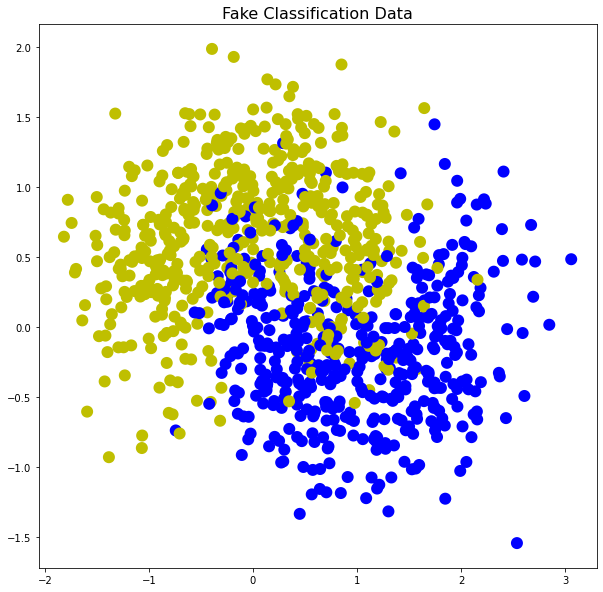

In [34]:
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
Xm, ym = make_moons(n_samples=50000, noise=0.4, random_state=53)

plt.figure(figsize=(10,10))
colors=['b' if y == 1 else 'y' for y in ym[:1000]]
plt.scatter(Xm[:1000, 0], Xm[:1000, 1], c=colors, linewidths=6)
plt.title('Fake Classification Data', fontsize=16)

In [35]:
# code goes here
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
X_train, X_test, y_train, y_test = train_test_split(Xm, ym, test_size=0.2, random_state=49)
param_grid = {'max_depth': np.arange(1, 20), 'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}

tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 3)

tree.fit(X_train, y_train)
# y_preds = tree.predict_proba(X_test)[:, 1]
# tree_performance = roc_auc_score(y_test, y_preds)

# print('DecisionTree: Area under the ROC curve = {}'.format(tree_performance))

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]})

In [36]:
tree.best_params_

{'max_depth': 9, 'max_leaf_nodes': 40, 'min_samples_split': 2}

In [37]:
new_tree = DecisionTreeClassifier(max_depth=9, max_leaf_nodes=40, min_samples_split=2)
new_tree.fit(X_train, y_train)
y_preds = new_tree.predict_proba(X_test)[:, 1]
tree_performance = roc_auc_score(y_test, y_preds)

print('DecisionTree: Area under the ROC curve = {}'.format(tree_performance))

DecisionTree: Area under the ROC curve = 0.9317615800000001


# Problem 2: The XOR Gate Revisted (20%)
## In this problem we'll explore the xor gate when we add noise to it and examine the decision boundary.

In [60]:
import numpy as np
import pandas as pd
%pylab inline

np.random.seed(1234)

from matplotlib.colors import ListedColormap

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


## Part 0: Generate data
 - ### Generate 2000 points of two dimensional random data (`X.shape` should be `(2000,2)`)
 - ### Compute `y_xor`

In [61]:
x = np.random.rand(2000, 2) > 0.5
y_xor = np.logical_xor(x[:, 0], x[:, 1])

## Part 1: Fit two classifiers
 - ### Partition the data into train and test
 - ### Fit both logistic regression and a single decision tree to the `x_or` data.
 - ### Compute the accuracy out of sample for each model
 - ### Make a plot of the decision boundary (NB see the class notes for help) and comment on what you see

In [62]:
# your code here
x_train, x_test, y_xor_train, y_xor_test = train_test_split(x, y_xor, test_size = 0.3)

In [63]:
def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", )
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", )
        plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

In [64]:
# your code here
# make some plots
lr = LogisticRegression()
lr.fit(x_train, y_xor_train)
x_test_lrpred = lr.predict(x_test)
accuracy_score(x_test_lrpred,y_xor_test)


0.51

/Users/panqian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.


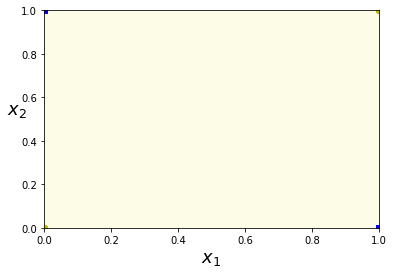

In [65]:
plot_decision_boundary(lr, x_train, y_xor_train, axes=[0, 1, 0, 1], legend=False, plot_training=True)

In [66]:
max_depth = 2
dt = DecisionTreeClassifier()
dt.fit(x_train, y_xor_train)
x_test_dtpred = dt.predict(x_test)
accuracy_score(y_xor_test, x_test_dtpred)

1.0

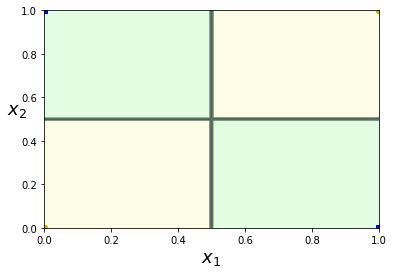

In [59]:
plot_decision_boundary(dt, x_train, y_xor_train, axes=[0, 1, 0, 1], legend=False, plot_training=True)

In [ ]:
# PUT COMMENTS HERE 

## Part 2: Add Noise
 - ### Add a small amount of random normal noise to both dimensions of X
 - ### Find what "small" is by plotting the data and making sure the clusters don't overlap
 - ### Repeat fitting both a decision tree and logistic regression to the data
 - ### Compute the out of sample accuracies.
 - ### Plot the decision boundaries and comment on the results

In [68]:
x_noisy = x + 0.05 * np.random.randn(x.shape[0], x.shape[1])
x_train_noisy, x_test_noisy, y_xor_train_noisy, y_xor_test_noisy = train_test_split(x_noisy, y_xor, test_size = 0.3)


In [69]:
# your code here
# make some plots
lr_noisy = LogisticRegression()
lr_noisy.fit(x_train_noisy, y_xor_train_noisy)
x_test_lrpred_noisy = lr_noisy.predict(x_test_noisy)
accuracy_score(x_test_lrpred_noisy,y_xor_test_noisy)

0.43333333333333335

/Users/panqian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.


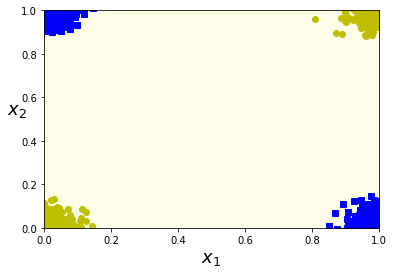

In [70]:
plot_decision_boundary(lr_noisy, x_train_noisy, y_xor_train_noisy, axes=[0, 1, 0, 1], legend=False, plot_training=True)

In [71]:
dt_noisy = DecisionTreeClassifier()
dt_noisy.fit(x_train_noisy, y_xor_train_noisy)
x_test_dtpred_noisy = dt_noisy.predict(x_test_noisy)
accuracy_score(y_xor_test_noisy, x_test_dtpred_noisy)

1.0

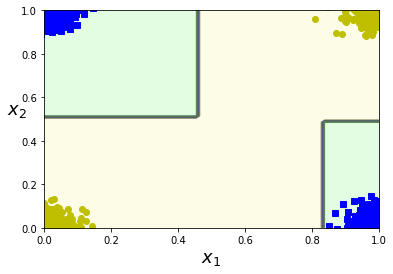

In [72]:
plot_decision_boundary(dt_noisy, x_train_noisy, y_xor_train_noisy, axes=[0, 1, 0, 1], legend=False, plot_training=True)

In [ ]:
# PUT COMMENTS HERE!

## Part 3: Add More Noise!
 - ### Add more noise to the point where the clusters slightly overlap
 - ### Fit THREE models: an unrestricted decision tree, a regularized tree, and logistic regression
 - ### Compute the out of sample accuracies.
 - ### Plot the decision boundaries and comment on the results

In [ ]:
# x_noisy = x + 0.25 * np.random.randn(x.shape[0], x.shape[1])

# lr_noisy = LogisticRegression(C=1e3)
# # add code here


# dt_noisy = DecisionTreeClassifier()
# # add code here


# # add more code for restricted tree


# # plotting code here

In [74]:
x_noisy = x + 0.25 * np.random.randn(x.shape[0], x.shape[1])
x_train_noisy, x_test_noisy, y_xor_train_noisy, y_xor_test_noisy = train_test_split(x_noisy, y_xor, test_size = 0.3)

In [75]:
lr_noisy = LogisticRegression(C=1e3)
lr_noisy.fit(x_train_noisy, y_xor_train_noisy)
x_test_lrpred_noisy = lr_noisy.predict(x_test_noisy)
accuracy_score(x_test_lrpred_noisy,y_xor_test_noisy)

0.5116666666666667

/Users/panqian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.


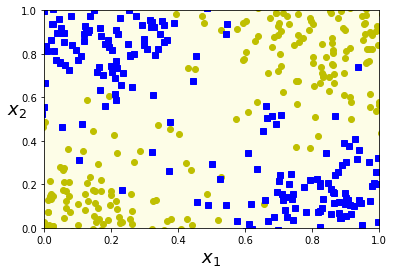

In [76]:
plot_decision_boundary(lr_noisy, x_train_noisy, y_xor_train_noisy, axes=[0, 1, 0, 1], legend=False, plot_training=True)

# Problem 3: The limits of trees and ensembles (30%)
## In this problem we will look at the limits of trees and ensembles compared to other methods. Specifically, we will investigate how they extrapolate vs interpolate

In [79]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
%pylab inline

np.random.seed(1234)

Populating the interactive namespace from numpy and matplotlib


## Part 0: generate some timeseries data of the form $y=c_0 x + c_1 \cos(\omega x) + \epsilon$
### where $\epsilon$ is noise

### TODO
 - ### Generate the data
 - ### Partition the data randomly into train and test
 - ### Plot the data, with train and test as different colors

<AxesSubplot:>

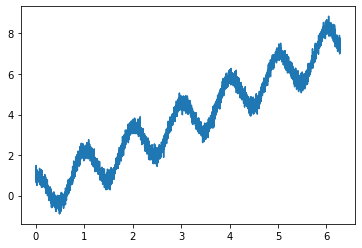

In [121]:
num_points = 4096
coef = 1.2
omega = 2 * np.pi
noise_ampl = 0.2

x_vals = np.linspace(0, 2 * pi, num_points)
y_vals = np.cos(omega * x_vals) + coef * x_vals + noise_ampl * np.random.normal(size=(x_vals.shape[0],))
pd.Series(y_vals, index=x_vals).plot()

In [122]:
#your code here for 60/40 train/test split
x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=0.4)
assert x_train.shape[0] == 2457, "something went wrong"

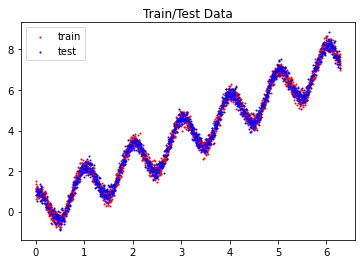

In [123]:
# plotting code here
plt.scatter(x_train, y_train,label='train', c='r', s=1)
plt.scatter(x_test, y_test, label='test', c='b', s=1)
plt.title('Train/Test Data')
plt.legend()

## Part 2: Evaluate some estimators
In this part we'll use mean squared error on the test set as a metric. 

 - ### For a bunch of different estimators, 
   - evaluate the test set MSE
   - plot both `y_test` and the predicted value for `x_test` as a function of `x_test`, in different colors
 - ### Use 
   - decision trees of depths 2, 4, 6, 8, 10, 12, 14, 16
   - linear regression
 - ### Additionally, 
   - calculate and print the MSE for a constant guess based on the train set
   - calculate and print the MSE for a constant guess based on the test set


In [124]:
# some helpful imports
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

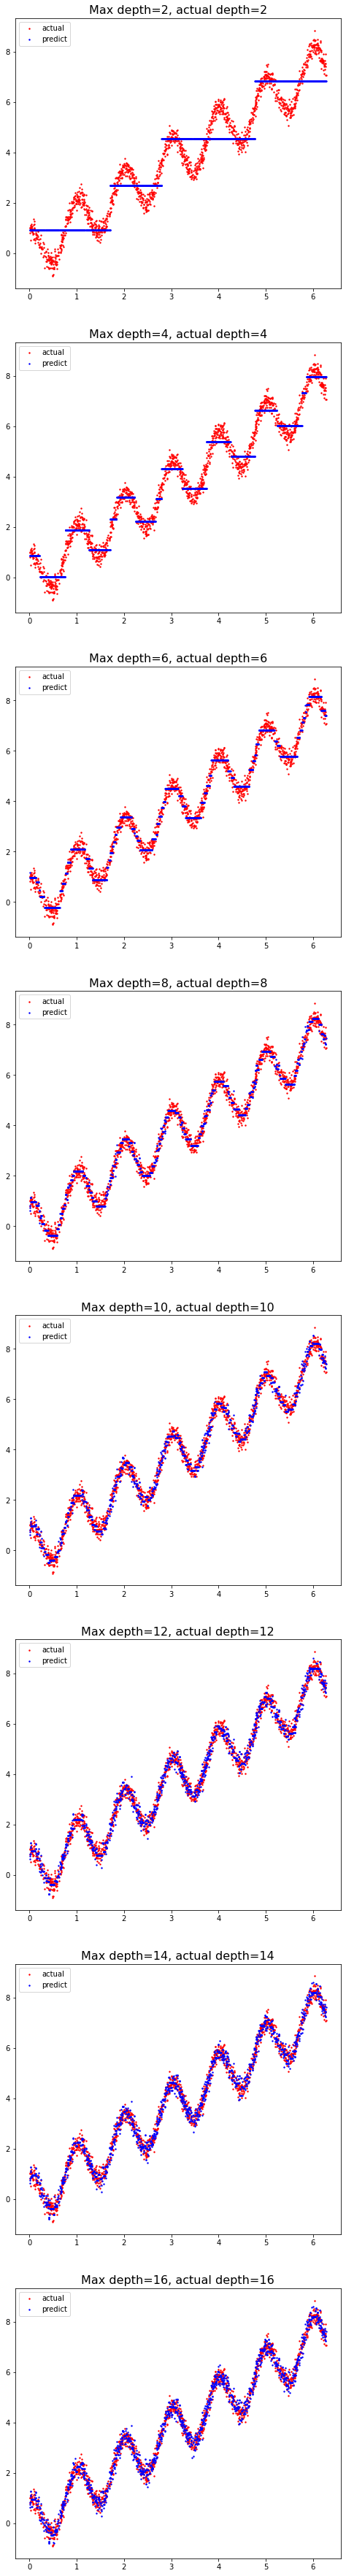

In [125]:
# your code here for evaluating estimators
mse = []
depths = [2,4,6,8,10,12,14,16]
columns = []
plt.figure(figsize=(8, 8 * len(depths)))
for i in depths:
    tree = DecisionTreeRegressor(criterion='mse', max_depth=i, random_state=42)
    tree.fit(x_train.reshape(-1, 1), y_train)
    y_pred = tree.predict(x_test.reshape(-1, 1))
    columns.append('mse_tree_depth_{}'.format(i))
    mse.append(mean_squared_error(y_test, y_pred))
    plt.subplot(len(depths), 1, i//2)
    plt.scatter(x_test, y_test, label='actual', c='r', s=2)
    plt.scatter(x_test, y_pred, label='predict', c='b', s=2)
    plt.title("Max depth={}, actual depth={}".format(i, tree.tree_.max_depth), fontsize=16)
    plt.legend()


# NB: consider writing a helper function for all of the 
# evaluation of estimators

Plot for linear regression


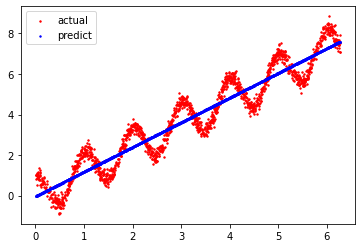

In [126]:
reg = LinearRegression()
reg.fit(np.array([x_train]).T, y_train)
y_pred = reg.predict(np.array([x_test]).T)
mse.append(mean_squared_error(y_test,y_pred))
columns.append('linear regression'.format(i))
print('Plot for linear regression'.format(i))
plt.clf()
plt.scatter(x_test, y_test, label='actual', c='r', s=2)
plt.scatter(x_test, y_pred, label='predict', c='b', s=2)
plt.legend()
plt.show()

const_guess = x_train.mean()
y_pred_const = [const_guess for i in range(len(y_test))]
y_train_const = [const_guess for i in range(len(y_train))]
mse.append(mean_squared_error(y_train, y_train_const))
mse.append(mean_squared_error(y_test,y_pred_const))
columns += ['mse_const_train','mse_const_test']


In [127]:
pd.DataFrame(np.array([mse]), index=['mse'], columns = columns)

,mse_tree_depth_2,mse_tree_depth_4,mse_tree_depth_6,mse_tree_depth_8,mse_tree_depth_10,mse_tree_depth_12,mse_tree_depth_14,mse_tree_depth_16,linear regression,mse_const_train,mse_const_test
mse,0.610871,0.142107,0.059512,0.051978,0.060324,0.068567,0.076524,0.079837,0.533874,5.891641,5.855061


## Part 3: Partition the data, treating `x` as time, and respecting time. 

### Re-partition the data into train/test where the test set comes AFTER the train set
### Plot the data again, putting a vertical line separating the train and test data

In [109]:
# your code here for 60/40 train/test split that respects time
split = int(len(x_vals)*0.6)
x_train = x_vals[:split]
x_test = x_vals[split:]
y_train = y_vals[:split]
y_test = y_vals[split:]

assert x_train.max() < x_test.min(), 'something has gone wrong splitting the data'

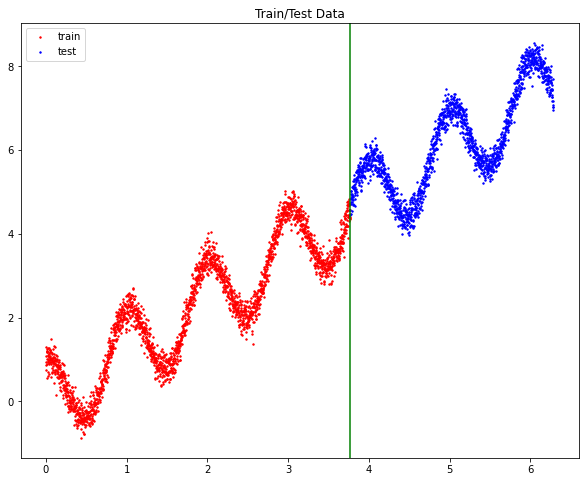

In [111]:
# plotting code here
plt.figure(figsize=(10,8))
plt.scatter(x_train, y_train,label='train', c='r', s=2)
plt.scatter(x_test, y_test, label='test', c='b', s=2)
plt.axvline(x=x_vals[split], c='g')
plt.title('Train/Test Data')
plt.legend()

## Part 4: Evaluate some estimators
We will again use test set MSE as a metric

 - ### For a bunch of different estimators, 
   - evaluate the test set MSE
   - plot both `y_test` and the predicted value for `x_test` as a function of `x_test`, in different colors
 - ### Use 
   - decision trees of depths 2, 4, 6, 8, 10, 12, 14, 16
   - linear regression
 - ### Additionally, 
   - calculate and print the MSE for a constant guess based on the train set
   - calculate and print the MSE for a constant guess based on the test set
   - __THIS ONE IS NEW__: calculate and print the MSE for guessing the previous (1-step lag) in the test set


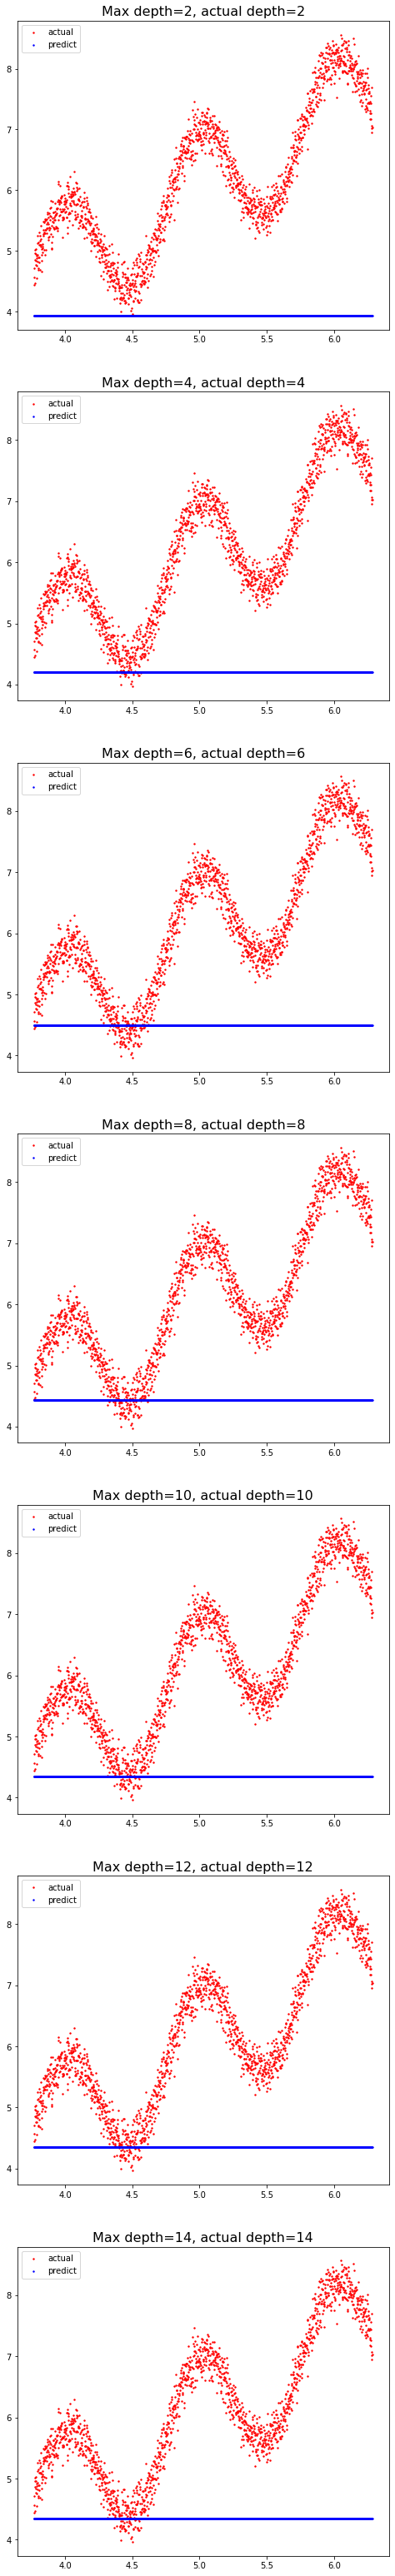

In [114]:
# your code here
# other than the time-lag problem, this should be identical code (not results) as part 2
mse = []
depths = [2,4,6,8,10,12,14,16]
columns = []
plt.figure(figsize=(8, 8 * len(depths)))
for i in depths:
    tree = DecisionTreeRegressor(criterion='mse', max_depth=i, random_state=42)
    tree.fit(x_train.reshape(-1, 1), y_train)
    y_pred = tree.predict(x_test.reshape(-1, 1))
    columns.append('mse_tree_depth_{}'.format(i))
    mse.append(mean_squared_error(y_test, y_pred))
    plt.subplot(len(depths), 1, i//2)
    plt.scatter(x_test, y_test, label='actual', c='r', s=2)
    plt.scatter(x_test, y_pred, label='predict', c='b', s=2)
    plt.title("Max depth={}, actual depth={}".format(i, tree.tree_.max_depth), fontsize=16)
    plt.legend()

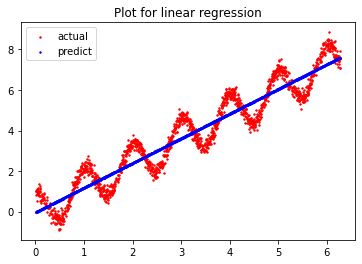

In [128]:
reg = LinearRegression()
reg.fit(np.array([x_train]).T, y_train)
y_pred = reg.predict(np.array([x_test]).T)
mse.append(mean_squared_error(y_test,y_pred))
columns.append('linear regression'.format(i))
plt.clf()
plt.scatter(x_test, y_test, label='actual', c='r', s=2)
plt.scatter(x_test, y_pred, label='predict', c='b', s=2)
plt.title('Plot for linear regression')
plt.legend()
plt.show()

const_guess = x_train.mean()
y_pred_const = [const_guess for i in range(len(y_test))]
y_train_const = [const_guess for i in range(len(y_train))]
mse.append(mean_squared_error(y_train, y_train_const))
mse.append(mean_squared_error(y_test,y_pred_const))
lag_1_test = np.roll(y_test,1)
mse.append(mean_squared_error(y_test[1:],lag_1_test[1:]))

columns += ['mse_const_train','mse_const_test','mse_lag_1_test']

In [117]:
pd.DataFrame(np.array([mse]), index=['mse'], columns = columns)

,mse_tree_depth_2,mse_tree_depth_4,mse_tree_depth_6,mse_tree_depth_8,mse_tree_depth_10,mse_tree_depth_12,mse_tree_depth_14,linear regression,mse_const_train,mse_const_test,mse_lag_1_test,linear regression,mse_const_train,mse_const_test,mse_lag_1_test
mse,6.203717,5.04656,4.011244,4.221815,4.52776,4.52776,4.52776,0.654716,2.163893,19.507623,0.076842,0.654716,2.163893,19.507623,0.076842


## Part 5: Comment on the results
What estimators do best in each case. Why is that? 

# put comments here
In part 2, we notice that decision tree with depth=8 has the lowest MSE. In part 4, one-step lag has the lowest MES. The reason is that in part 2, the training and testing data are randomly selected. Thus there's no linear relationship between them. A decision tree can fit the data better in this case. For the second case, test and train sets are not overlap with each other and the value of test is obviously larger than the train data. As a result, decision tree can hardly give a good prediction. 